In [70]:
import pandas     as pd
import tensorflow as tf
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from typing import Any, Tuple
from copy import deepcopy

In [71]:
TESTING_WINDOW_SIZES = ['10min']
DATA_FOLDER          = './datasets/ambient_measurements/2022'
DATA_FILENAMES       = ['hum.csv', 'temp.csv']
VARIABLE_NAMES       = ['hum_level', 'temp_level']
PREFER_MAE_OVER_MSE  = False

SPLIT_DATE           = '2022-05-29 00:00:00'
INTERPOLATION_METHOD = 'linear'
INTERPOLATION_ORDER  = 3
RESAMPLE_FREQ        = '5min'

#MODEL PARAMETERS
PATIENCE             = 10
EPOCHS               = 100
WINDOW_SIZE          = 50 #keep in mind that each data point is 5 minutes apart
BATCH_SIZE           = 32 
TIMESTEPS_AHEAD      = 36 #keep in mind that each data point is 5 minutes apart
SHUFFLE_BUFFER_SIZE  = 1000

In [72]:
data = pd.read_csv(f"{DATA_FOLDER}/{DATA_FILENAMES[0]}", index_col=0, parse_dates=True)
data.head()

,hum_level
time,
2022-05-09 21:22:18,50.23
2022-05-09 21:24:48,50.30
2022-05-09 21:27:18,50.33
2022-05-09 21:32:18,50.37
2022-05-09 21:37:18,50.41


# Resample and Interpolate 

This is done to make the model more resilient to periods of time where there is no data. This is done by resampling the data to a fixed frequency and then interpolating the missing values.

In [73]:
data = data.interpolate(method=INTERPOLATION_METHOD, order=INTERPOLATION_ORDER).\
            resample(RESAMPLE_FREQ).mean().interpolate(method=INTERPOLATION_METHOD, order=INTERPOLATION_ORDER)

# Splitting the data

In [74]:
# Split the data into training and testing sets
train = deepcopy(data[:SPLIT_DATE])
test = deepcopy(data[SPLIT_DATE:])

# Plot the data
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train[VARIABLE_NAMES[0]], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, y=test[VARIABLE_NAMES[0]], mode='lines', name='Test'))
fig.update_layout(title='Humidity', xaxis_title='Time', yaxis_title='Humidity')
fig.show()

# Prepare the data for training and testing

After the data has been resampled, interpolated, it is split into training and testing data. The training data is used to train the model and the testing data is used to evaluate the model.

In [75]:
def windowed_dataset(series: np.array,
                     window_size: int,
                     batch_size: int,
                     shuffle_buffer: int,
                     timesteps_ahead: int = 12, 
                     shuffle: bool = True) -> tf.data.Dataset:

    """
    Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int)       - the number of time steps to average
      batch_size (int)        - the batch size
      timestep_ahead (int)    - the number of time steps to predict
      shuffle_buffer(int)     - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + timesteps_ahead, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + timesteps_ahead))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-timesteps_ahead], window[-timesteps_ahead:]))

    # Shuffle the windows
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [76]:
train_dataset = windowed_dataset(train[VARIABLE_NAMES[0]], WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, TIMESTEPS_AHEAD)
test_dataset = windowed_dataset(test[VARIABLE_NAMES[0]], WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, TIMESTEPS_AHEAD, shuffle=False)

In [77]:
# Print properties of a single batch
for windows in train_dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 50)
shape of second element: (32, 36)


# Build the baseline model

In [78]:
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
])

model_baseline.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 10)                510       
                                                                 
 dropout_10 (Dropout)        (None, 10)                0         
                                                                 
 dense_21 (Dense)            (None, 10)                110       
                                                                 
 dropout_11 (Dropout)        (None, 10)                0         
                                                                 
 dense_22 (Dense)            (None, 36)                396       
                                                                 
Total params: 1016 (3.97 KB)
Trainable params: 1016 (3.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
model_baseline.compile(loss      = tf.losses.MeanSquaredError(),
                       optimizer = "adam",
                       metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')

# Train the model and save the history
history = model_baseline.fit(train_dataset,
                             epochs=EPOCHS,
                             validation_data=test_dataset,
                             callbacks=[early_stopping])

Epoch 1/100
     56/Unknown - 1s 3ms/step - loss: 2799.6411 - mae: 50.3055 - mse: 2799.6411

170/170 [==============================] - 1s 4ms/step - loss: 2000.1703 - mae: 41.0259 - mse: 2000.1703 - val_loss: 847.9519 - val_mae: 24.4611 - val_mse: 847.9519
Epoch 2/100
170/170 [==============================] - 1s 4ms/step - loss: 761.6970 - mae: 21.2098 - mse: 761.6970 - val_loss: 224.4445 - val_mae: 13.8297 - val_mse: 224.4445
Epoch 3/100
170/170 [==============================] - 1s 4ms/step - loss: 574.2163 - mae: 17.7397 - mse: 574.2163 - val_loss: 169.2711 - val_mae: 12.6895 - val_mse: 169.2711
Epoch 4/100
170/170 [==============================] - 1s 4ms/step - loss: 549.5970 - mae: 16.9789 - mse: 549.5970 - val_loss: 190.2808 - val_mae: 13.6019 - val_mse: 190.2808
Epoch 5/100
170/170 [==============================] - 1s 4ms/step - loss: 526.2323 - mae: 16.6080 - mse: 526.2323 - val_loss: 163.3799 - val_mae: 12.5931 - val_mse: 163.3799
Epoch 6/100
170/170 [==============================] - 1s 4ms/step - loss: 486.4290 - mae: 15.8289 - mse: 486.4290 - val_loss: 135.5755

In [80]:
# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

In [81]:
type(test_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [82]:
baseline_eval = model_baseline.evaluate(test_dataset)

     42/Unknown - 0s 3ms/step - loss: 60.5645 - mae: 7.5773 - mse: 60.5645

129/129 [==============================] - 0s 2ms/step - loss: 90.4437 - mae: 9.2885 - mse: 90.4437


In [83]:
def plot_random_predictions(model_baseline: Any,
                            test_dataset: Any,
                            N: int = 12,
                            COLS: int = 4) -> None:
    """
    Plots N random predictions from the model_baseline compared to expected values from the test_dataset.
    
    Parameters:
    - model_baseline: The model used for making predictions. It must have a .predict() method.
    - test_dataset: The dataset to test the model on, expected to yield tuples of (features, labels).
    - N: The number of random predictions to plot. Default is 12.
    - COLS: The number of columns in the subplot grid. Default is 4.
    
    Returns:
    None. Displays a matplotlib figure with the plots.
    """
    # Make predictions on the test dataset
    baseline_preds = model_baseline.predict(test_dataset)
    
    # Concatenate all expected labels from the test dataset
    inputs = np.concatenate([x for x, y in test_dataset], axis=0)
    expected = np.concatenate([y for x, y in test_dataset], axis=0)
    
    # Randomly select N predictions for plotting
    samples = np.random.randint(0, len(baseline_preds), N)
    
    # Create subplots
    _, subplots = plt.subplots(N//COLS, COLS, figsize=(15, 10))
    subplots = subplots.ravel()
    
    # Plot each selected sample's expected vs. predicted values
    for i, sample in enumerate(samples):
        
        # concatenate the inputs and expected values, but plot the 
        # inputs in a different color than the expected values
        joint = np.concatenate([inputs[sample], expected[sample]])  
        xrange = range(len(joint))
        subplots[i].plot(xrange, joint, label='Expected', color='blue')
        subplots[i].plot(xrange, [None]*len(inputs[sample]) + list(baseline_preds[sample]), label='Predicted', color='red')
        subplots[i].legend()
        subplots[i].set_title(f'Prediction {sample}')
        
    plt.tight_layout()
    plt.show()


      1/Unknown - 0s 43ms/step

129/129 [==============================] - 0s 2ms/step


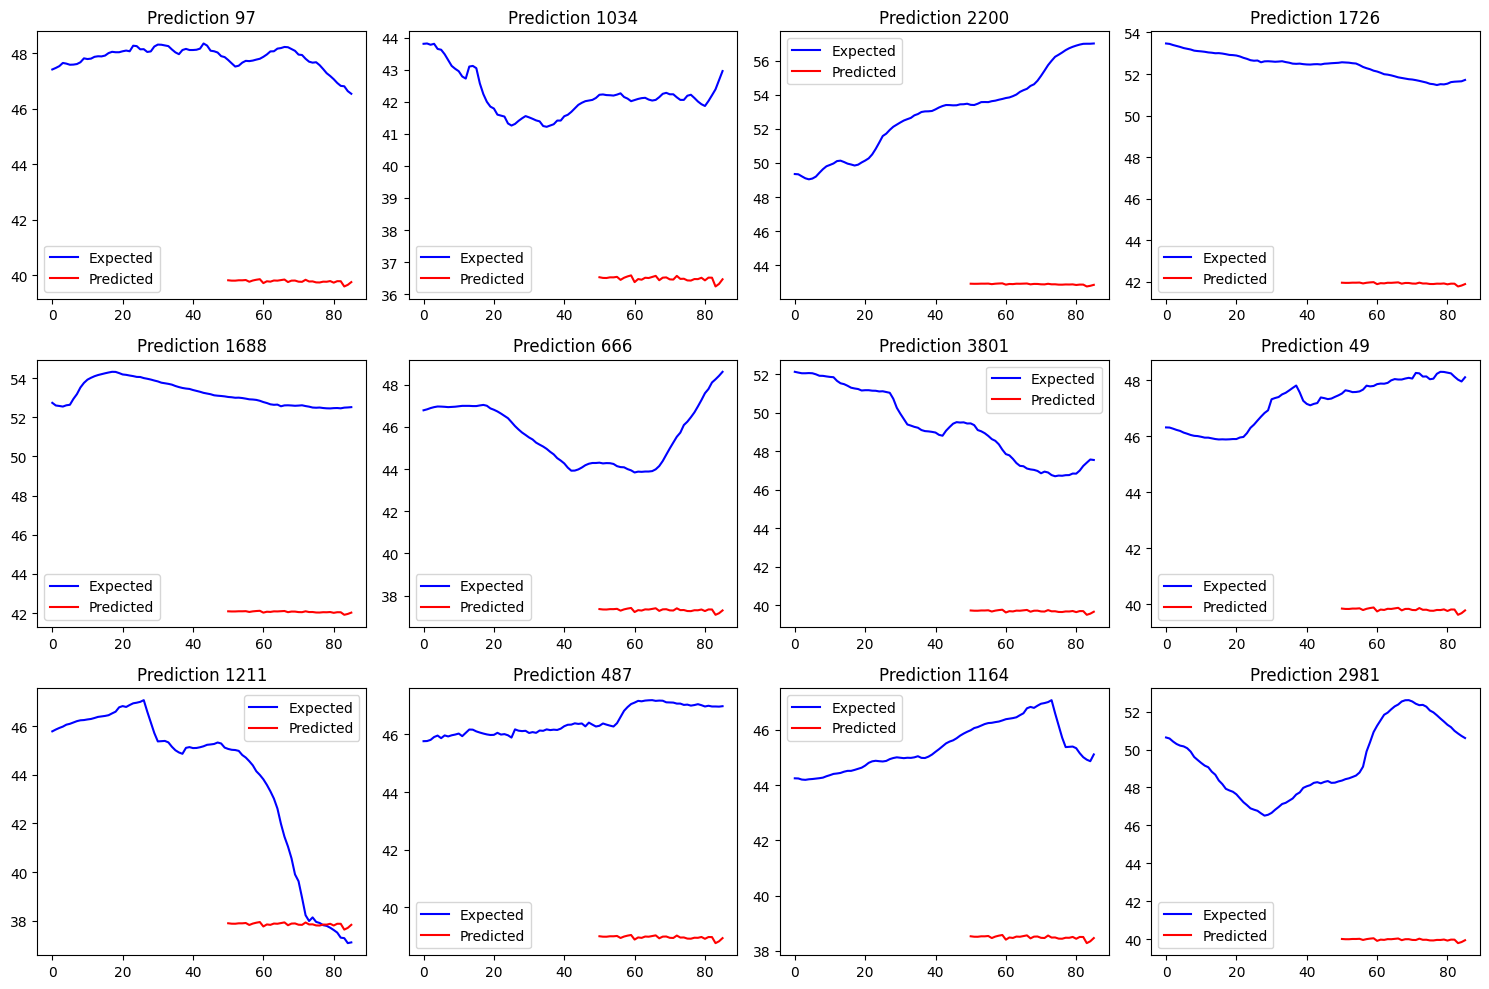

In [84]:
plot_random_predictions(model_baseline, test_dataset, N=12, COLS=4)

# Now that we have some benchmark, lets build the model


In [85]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE]),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
    tf.keras.layers.Lambda(lambda x: x * 100)
])

model1.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_33 (Lambda)          (None, 50, 1)             0         
                                                                 
 conv1d_40 (Conv1D)          (None, 50, 3)             12        
                                                                 
 conv1d_41 (Conv1D)          (None, 50, 3)             30        
                                                                 
 conv1d_42 (Conv1D)          (None, 50, 3)             30        
                                                                 
 flatten_16 (Flatten)        (None, 150)               0         
                                                                 
 dropout_12 (Dropout)        (None, 150)               0         
                                                                 
 dense_23 (Dense)            (None, 10)              

In [86]:
model1.compile(loss = tf.losses.MeanSquaredError(),
               optimizer = "adam",
               metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')

# Train the model and save the history
history = model1.fit(train_dataset,
                     epochs=EPOCHS,
                     validation_data=test_dataset,
                     callbacks=[early_stopping])

# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

Epoch 1/100
170/170 [==============================] - 1s 4ms/step - loss: 1830.4712 - mae: 31.7575 - mse: 1830.4712 - val_loss: 368.6545 - val_mae: 16.2530 - val_mse: 368.6545
Epoch 2/100
170/170 [==============================] - 1s 4ms/step - loss: 288.4420 - mae: 12.9052 - mse: 288.4420 - val_loss: 84.3238 - val_mae: 8.4081 - val_mse: 84.3238
Epoch 3/100
170/170 [==============================] - 1s 4ms/step - loss: 114.2816 - mae: 7.9674 - mse: 114.2816 - val_loss: 55.6319 - val_mae: 6.7707 - val_mse: 55.6319
Epoch 4/100
170/170 [==============================] - 1s 4ms/step - loss: 66.2662 - mae: 6.2293 - mse: 66.2662 - val_loss: 47.9925 - val_mae: 6.1863 - val_mse: 47.9925
Epoch 5/100
170/170 [==============================] - 1s 4ms/step - loss: 50.8518 - mae: 5.4867 - mse: 50.8518 - val_loss: 46.0530 - val_mae: 6.0176 - val_mse: 46.0530
Epoch 6/100
170/170 [==============================] - 1s 4ms/step - loss: 42.2000 - mae: 5.0201 - mse: 42.2000 - val_loss: 43.3935 - val_mae:

      1/Unknown - 0s 22ms/step - loss: 3.4201 - mae: 1.7242 - mse: 3.4201

129/129 [==============================] - 1s 5ms/step


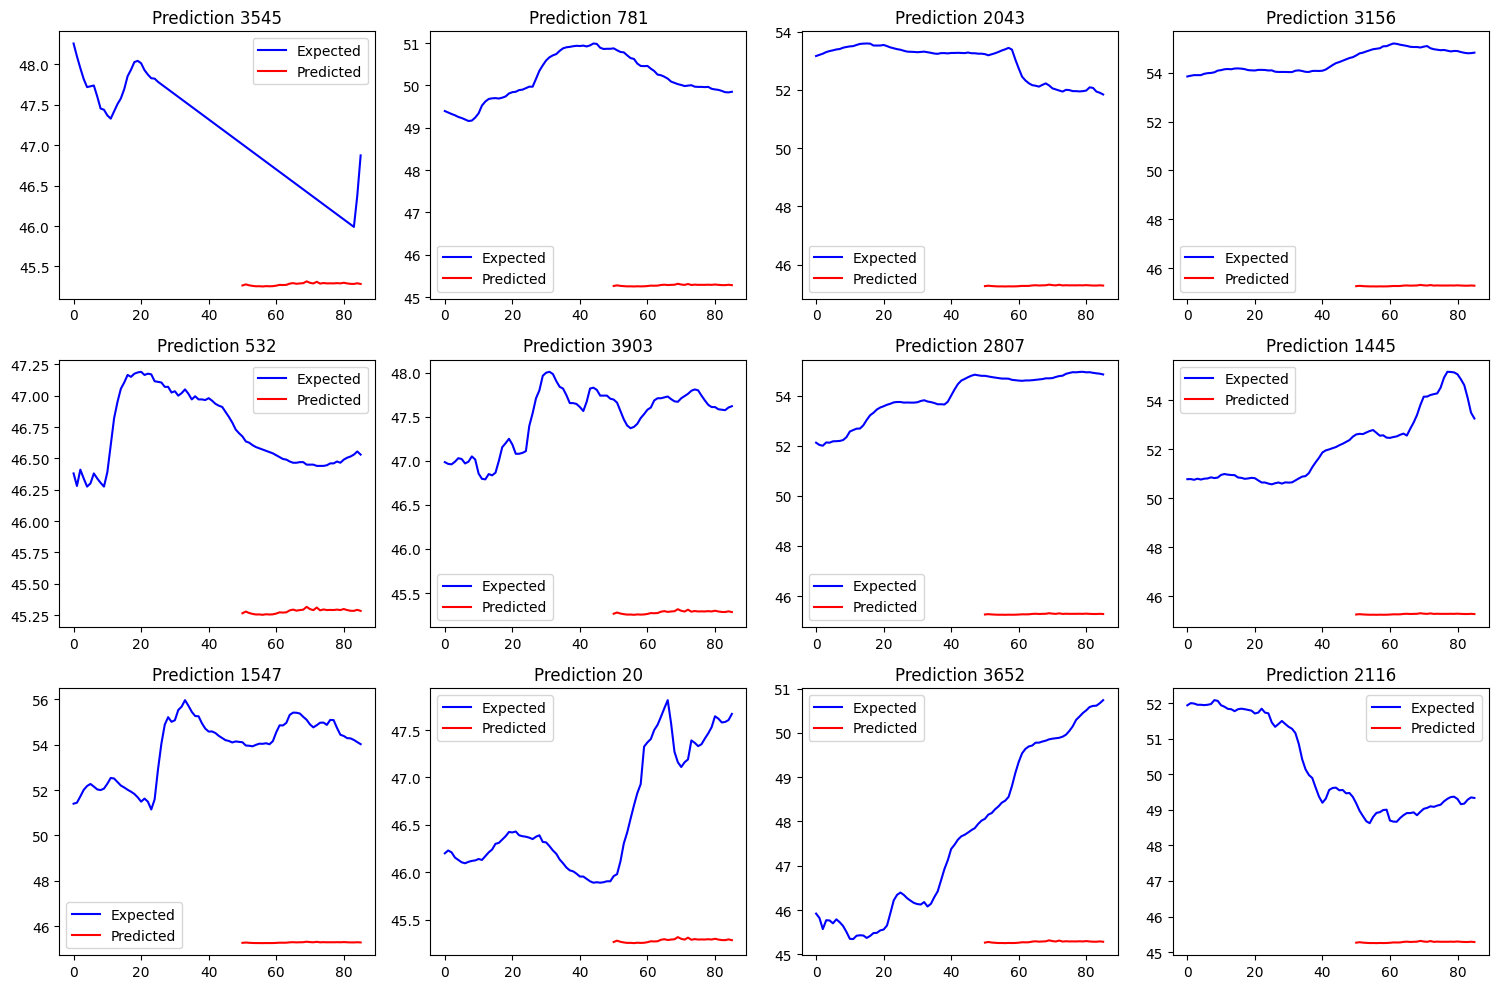

In [87]:
model1_eval = model1.evaluate(test_dataset)
plot_random_predictions(model1, test_dataset, N=12, COLS=4)

In [88]:
print(f"Baseline model: {baseline_eval}")
print(f"Model 1: {model1_eval}")

Baseline model: [90.44366455078125, 9.288529396057129, 90.44366455078125]
Model 1: [34.47809982299805, 5.08352518081665, 34.47809982299805]


# Create a more complex model

In [89]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE]),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),

    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2),

    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2),

    tf.keras.layers.GRU(10, return_sequences=True),
    tf.keras.layers.GRU(10, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
    tf.keras.layers.Lambda(lambda x: x * 100)
])
model2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_35 (Lambda)          (None, 50, 1)             0         
                                                                 
 conv1d_43 (Conv1D)          (None, 50, 3)             12        
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 25, 3)             0         
 ng1D)                                                           
                                                                 
 conv1d_44 (Conv1D)          (None, 25, 3)             30        
                                                                 
 max_pooling1d_23 (MaxPooli  (None, 12, 3)             0         
 ng1D)                                                           
                                                                 
 gru_18 (GRU)                (None, 12, 10)          

In [90]:
model2.compile(loss = tf.losses.MeanSquaredError(),
               optimizer = "adam",
               metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')

# Train the model and save the history
history = model2.fit(train_dataset,
                     epochs=EPOCHS,
                     validation_data=test_dataset,
                     callbacks=[early_stopping])

# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

Epoch 1/100
170/170 [==============================] - 4s 10ms/step - loss: 197.0482 - mae: 5.8920 - mse: 197.0482 - val_loss: 18.7415 - val_mae: 3.5919 - val_mse: 18.7415
Epoch 2/100
170/170 [==============================] - 1s 7ms/step - loss: 6.0807 - mae: 1.9285 - mse: 6.0807 - val_loss: 16.1358 - val_mae: 3.3726 - val_mse: 16.1358
Epoch 3/100
170/170 [==============================] - 1s 7ms/step - loss: 5.7883 - mae: 1.8793 - mse: 5.7883 - val_loss: 11.2867 - val_mae: 2.7328 - val_mse: 11.2867
Epoch 4/100
170/170 [==============================] - 1s 7ms/step - loss: 5.2865 - mae: 1.7922 - mse: 5.2865 - val_loss: 15.8854 - val_mae: 3.3942 - val_mse: 15.8854
Epoch 5/100
170/170 [==============================] - 1s 7ms/step - loss: 5.2323 - mae: 1.7793 - mse: 5.2323 - val_loss: 11.1530 - val_mae: 2.7574 - val_mse: 11.1530
Epoch 6/100
170/170 [==============================] - 1s 7ms/step - loss: 4.9489 - mae: 1.7320 - mse: 4.9489 - val_loss: 11.9176 - val_mae: 2.8874 - val_mse: 1

      1/Unknown - 0s 26ms/step - loss: 4.4841 - mae: 1.9748 - mse: 4.4841

129/129 [==============================] - 1s 2ms/step


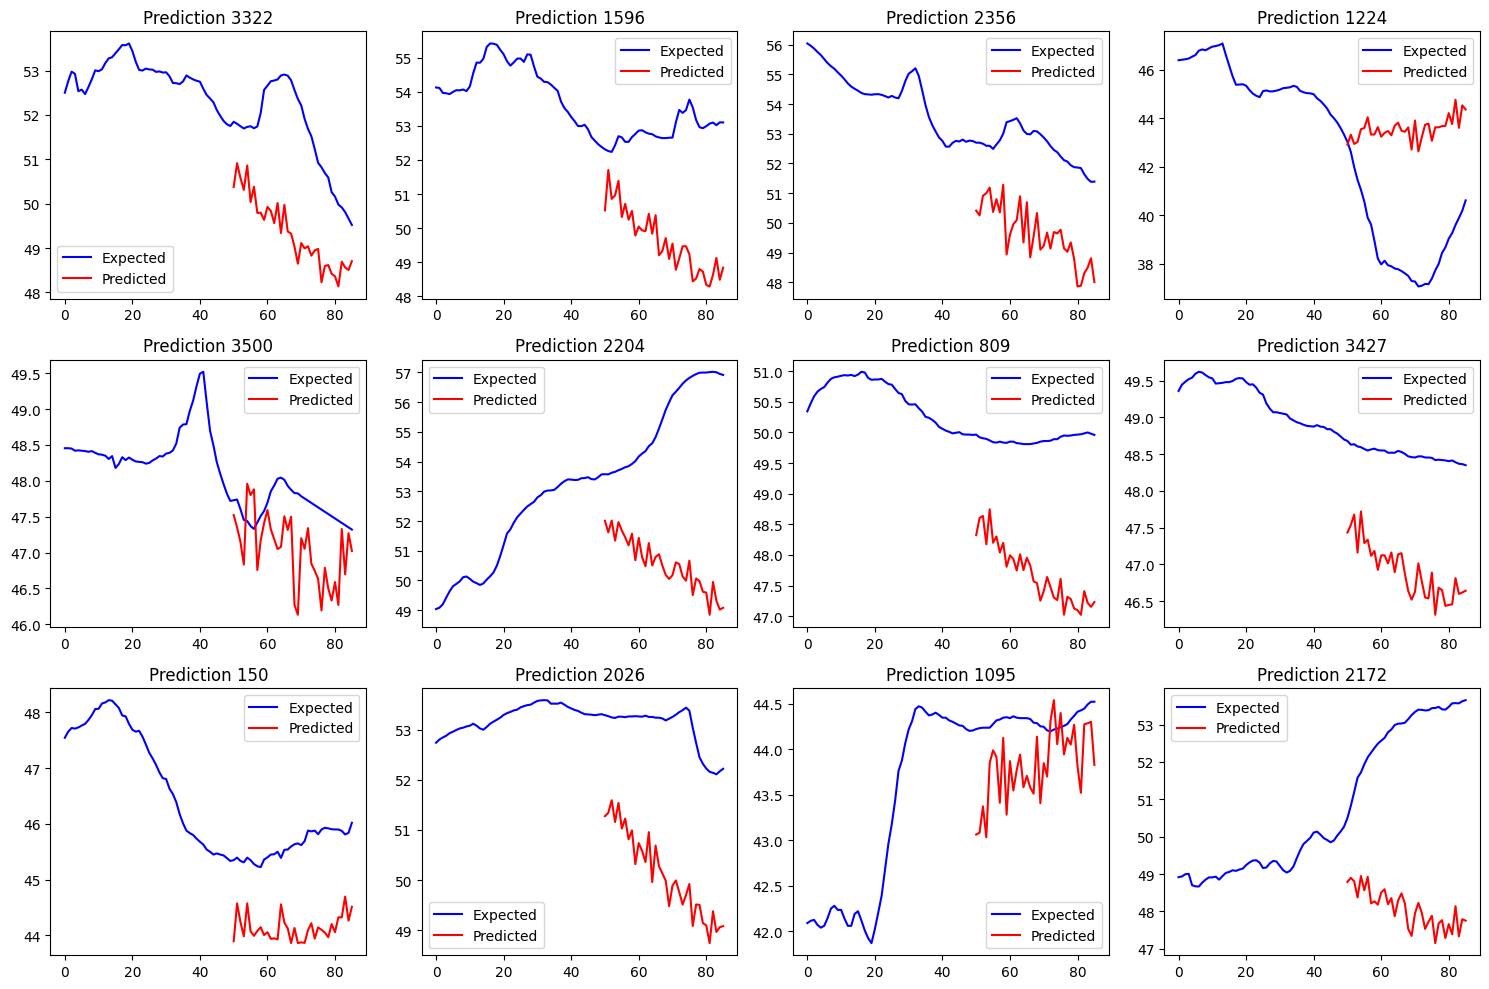

In [91]:
model2_eval = model2.evaluate(test_dataset)
plot_random_predictions(model2, test_dataset, N=12, COLS=4)

In [92]:
print(f"Baseline model: {baseline_eval}")
print(f"Model 1: {model1_eval}")
print(f"Model 2: {model2_eval}")

Baseline model: [90.44366455078125, 9.288529396057129, 90.44366455078125]
Model 1: [34.47809982299805, 5.08352518081665, 34.47809982299805]
Model 2: [7.527937412261963, 2.3308188915252686, 7.527937412261963]
